# House Hunters Linear Model

Linear model of human-interpretable features that will feed into an app to make recommendations for people looking to buy or sell a house.

## Pre-Processing

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp

# set display options
pd.set_option('display.max_columns', None)

In [2]:
# import dataset
housing = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0)
# real_estate = pd.read_csv('./data/Ames_Real_Estate_Data.csv')

#### Feature Cleaning

In [3]:
print("Number of rows before cleaning:", housing.shape[0])

Number of rows before cleaning: 2580


In [4]:
#Remove Outliers
housing = housing[np.logical_and(housing.SalePrice >= 40000, housing.SalePrice <= 750000)]
housing = housing[housing.GrLivArea < 4000]
housing = housing[housing.BedroomAbvGr > 0]
housing.loc[housing['GarageCars'] == 5, 'GarageCars'] = 4

#Remove Bad Classes
housing = housing[~housing.Neighborhood.isin(['Landmrk', 'GrnHill'])]

housing.MSZoning = housing.MSZoning.astype('string')
housing.MSZoning = housing.MSZoning.str.strip()
housing = housing[housing.MSZoning.isin(["FV", "RH", "RL", "RM"])]

housing = housing[housing.Functional.isin(["Typ", "Min1", "Min2"])]

housing.SaleType = housing.SaleType.astype('string')
housing.SaleType = housing.SaleType.str.strip()
housing = housing[housing.SaleType == 'WD']

housing = housing[housing.SaleCondition == 'Normal']


#Replace NAs
housing = housing.fillna(0)

In [5]:
print("Number of rows after cleaning:", housing.shape[0])

Number of rows after cleaning: 2254


#### Feature Engineering

In [6]:
#Area Calculations
housing['PorchTotSF'] = housing.OpenPorchSF + housing.EnclosedPorch + housing['3SsnPorch'] + housing.ScreenPorch
housing['BsmtSF'] = housing.BsmtFinSF1 + housing.BsmtFinSF2
housing.loc[housing['BsmtSF'] == 0, 'BsmtSF'] = exp(1)

#Log Transforms
housing['LogSalePrice'] = np.log(housing.SalePrice)
housing['LogLotArea'] = np.log(housing.LotArea)
housing['LogGrLivArea'] = np.log(housing.GrLivArea)
housing['LogBsmtSF'] = np.log(housing.BsmtSF)

#Categorical to Ordinal
housing.Neighborhood = housing.Neighborhood.replace({'MeadowV':1,'BrDale':2, 'IDOTRR':3, 'BrkSide':4, 'OldTown':5, 'Edwards':6, 'SWISU':7, 'Sawyer':8,\
                           'NPkVill':9, 'Blueste':10, 'NAmes':11, 'Mitchel':12, 'SawyerW':13, 'Gilbert':14, 'NWAmes':15, 'Greens':16, 'Blmngtn':17,\
                           'CollgCr':18, 'Crawfor':19, 'ClearCr':20, 'Somerst':21, 'Timber':22, 'Veenker':23, 'StoneBr':24,'NridgHt':25, 'NoRidge':26})
housing.BldgType = housing.BldgType.replace({'2fmCon':1,'Twnhs':2, 'Duplex':3, '1Fam':4, 'TwnhsE':5})
housing.HouseStyle = housing.HouseStyle.replace({'1.5Unf':1,'1.5Fin':2, 'SFoyer':3, 'SLvl':4, '1Story':5, '2.5Unf':6, '2Story':7, '2.5Fin':8})
housing.MoSold = housing.MoSold.replace({1:11, 9:10, 8:9, 6:8, 7:7, 11:6, 12:5, 2:4, 3:3, 10:2, 5:1, 4:0})

#Renumber Numerical
housing['NumBath'] = housing.FullBath + 0.5*housing.HalfBath + 0.5*housing.BsmtFullBath

#Binary HasBLANK Categories
housing['HasFinBsmt'] = np.where(housing.BsmtFinSF1 > 0, 1, 0)
housing['HasFinGarage'] = np.where(housing.GarageFinish == "Fin", 1, 0)
housing['HasFireplace'] = np.where(housing.Fireplaces > 0, 1, 0)
housing['HasPorch'] = np.where(housing.PorchTotSF > 0, 1, 0)
housing['HasDeck'] = np.where(housing.WoodDeckSF > 0, 1, 0)


#Binary Quality/Cond Categories
housing['HasAttchGarage'] = np.where(housing.GarageType == "Attchd", 1, 0)
housing['HasGreatElectric'] = np.where(housing.Electrical == "SBrkr", 1, 0)
housing['HasGreatHeat'] = np.where(housing.HeatingQC == "Ex", 1, 0)
housing['HasCentralAir'] = np.where(housing.CentralAir == "Y", 1, 0)

#### Feature Selection

In [7]:
model_cols = ['LogSalePrice', 'LogLotArea', 'LogGrLivArea', 'LogBsmtSF', 'OverallQual', 'OverallCond', 'YearBuilt',\
              'Neighborhood', 'BldgType', 'HouseStyle', 'MoSold', 'NumBath', 'GarageCars', 'BedroomAbvGr',\
              'HasFinBsmt', 'HasFinGarage', 'HasFireplace', 'HasPorch', 'HasDeck',\
              'HasAttchGarage', 'HasGreatElectric', 'HasGreatHeat', 'HasCentralAir']
housing = housing[model_cols]

## Model Generation

In [8]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import model_selection

In [9]:
y = housing['LogSalePrice']
x = housing.drop('LogSalePrice', axis=1)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=.2, random_state=0)

lm = LinearRegression()
lm.fit(x_train, y_train)

print("Train Score: %.4f" % lm.score(x_train, y_train))
print("Test Score:  %.4f" % lm.score(x_test, y_test))

Train Score: 0.9233
Test Score:  0.9117


Cross Validation
--------------------
Best parameter:  {'alpha': 0.00020565123083486514}
Best CV score:  0.9194


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

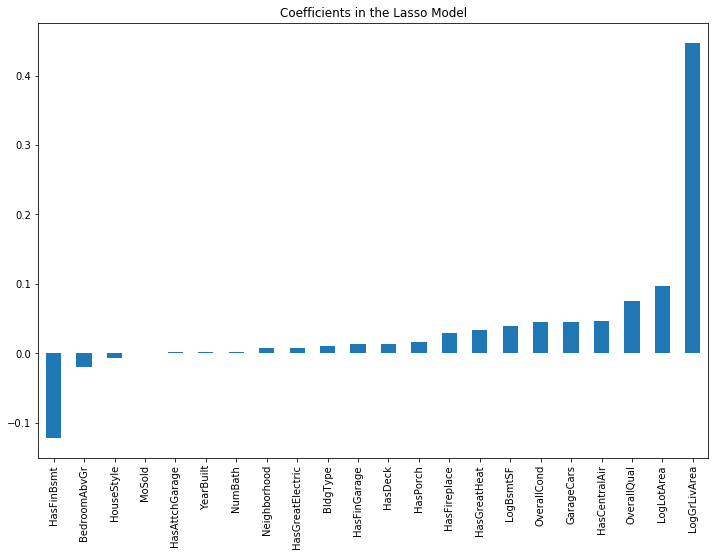

In [10]:
param_grid={'alpha': np.logspace(-5, -3, 100)}
grid_search = model_selection.GridSearchCV(estimator = Lasso(), param_grid = param_grid, cv=3)
grid_search.fit(x, y)

print("Cross Validation")
print("-" * 20)
print("Best parameter: ", grid_search.best_params_)
print("Best CV score:  %.4f" % grid_search.best_score_)

alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = alpha_cv).fit(x, y)
coef = pd.Series(lasso.coef_, index = x.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "bar", figsize = (12, 8))
plt.title("Coefficients in the Lasso Model")

Lasso(alpha=4.229242874389499e-05, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': 4.229242874389499e-05}
0.9107700579419123


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

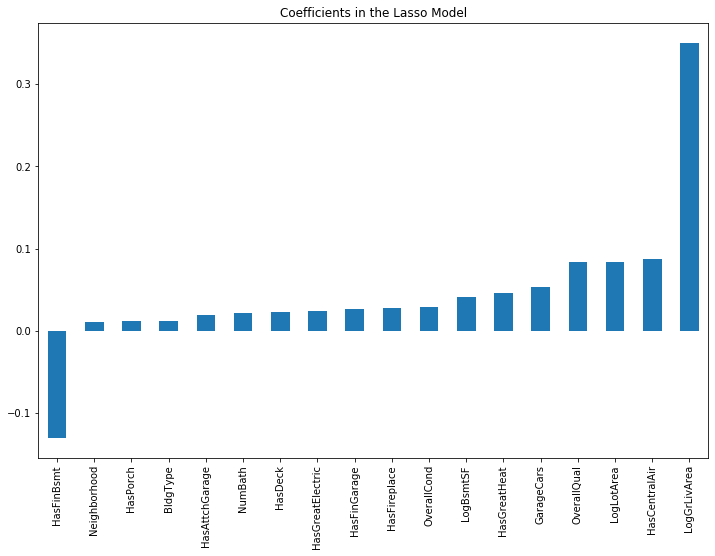

In [11]:
x = x.drop(['BedroomAbvGr', 'HouseStyle', 'MoSold', 'YearBuilt'], axis=1)
grid_search.fit(x, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = alpha_cv).fit(x, y)
coef = pd.Series(lasso.coef_, index = x.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "bar", figsize = (12, 8))
plt.title("Coefficients in the Lasso Model")

In [12]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=.2, random_state=0)

lm.fit(x_train, y_train)

print('Linear Model')
print('-'*20)
print("Train Score:   %.5f" % lm.score(x_train, y_train))
print("Test Score:    %.5f\n" % lm.score(x_test, y_test))

lasso.fit(x_train, y_train)

print('Penalized Linear Model')
print('-'*20)
print("Train Score: %.5f" % lasso.score(x_train, y_train))
print("Test Score:  %.5f" % lasso.score(x_test, y_test))

Linear Model
--------------------
Train Score:   0.91401
Test Score:    0.90441

Penalized Linear Model
--------------------
Train Score: 0.91401
Test Score:  0.90441


In [13]:
from sklearn.metrics import mean_squared_error

def expo(list_):
    return list(map(exp, list_))

print('Final Model')
print('-'*20)
lm.fit(x, y)
print("R^2 Score:  %.2f" % (100*lm.score(x, y)))
print("Mean Error: $%.0f\n" % mean_squared_error(expo(y), expo(lm.predict(x)), squared=False))

Final Model
--------------------
R^2 Score:  91.25
Mean Error: $21397



### Check Residuals

Text(0, 0.5, 'Residual House Price in $K')

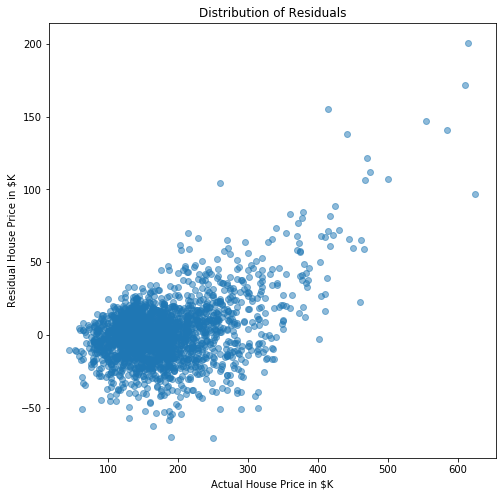

In [14]:
res_x = [target/1000 for target in expo(y)]
res_y = [(target - predict)/1000 for (target, predict) in zip(expo(y), expo(lm.predict(x)))]
plt.figure(figsize=(8,8))
plt.scatter(res_x, res_y, alpha = 0.5)
plt.title('Distribution of Residuals')
plt.xlabel('Actual House Price in $K')
plt.ylabel('Residual House Price in $K')

### Refit Model for Prices < $300K

Final Final Model (Truncated Linear Cross Validation)
--------------------
Train Score:   0.90698
Test Score:    0.89602

Final Final Model
--------------------
R^2 Score:  90.50
Mean Error: $15992



Text(0, 0.5, 'Residual House Price in $K')

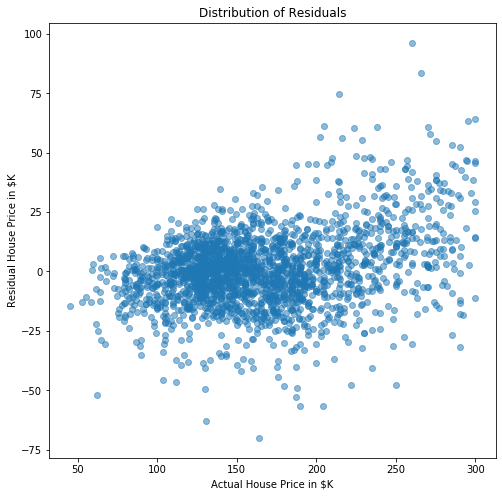

In [15]:
housing = housing[housing.LogSalePrice <= np.log(300000)]
x = housing.drop('LogSalePrice', axis=1)
y = housing['LogSalePrice']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=.2, random_state=0)

lm.fit(x_train, y_train)
print('Final Final Model (Truncated Linear Cross Validation)')
print('-'*20)
print("Train Score:   %.5f" % lm.score(x_train, y_train))
print("Test Score:    %.5f\n" % lm.score(x_test, y_test))

lm.fit(x, y)
print('Final Final Model')
print('-'*20)
print("R^2 Score:  %.2f" % (100*lm.score(x, y)))
print("Mean Error: $%.0f\n" % mean_squared_error(expo(y), expo(lm.predict(x)), squared=False))

res_x = [target/1000 for target in expo(y)]
res_y = [(target - predict)/1000 for (target, predict) in zip(expo(y), expo(lm.predict(x)))]
plt.figure(figsize=(8,8))
plt.scatter(res_x, res_y, alpha = 0.5)
plt.title('Distribution of Residuals')
plt.xlabel('Actual House Price in $K')
plt.ylabel('Residual House Price in $K')

## Save output to file

In [16]:
import pickle

model_cols = ['LogSalePrice', 'LogLotArea', 'LogGrLivArea', 'LogBsmtSF', 'OverallQual', 'OverallCond',\
              'Neighborhood', 'BldgType', 'NumBath', 'GarageCars',\
              'HasFinBsmt', 'HasFinGarage', 'HasFireplace', 'HasPorch', 'HasDeck',\
              'HasAttchGarage', 'HasGreatElectric', 'HasGreatHeat', 'HasCentralAir']
housing = housing[model_cols]
housing.to_pickle('linear_df.pkl')
housing = pd.read_pickle('linear_df.pkl')

pickle.dump(lm, open('linear_model.pkl', 'wb'))